In [1]:
from __future__ import absolute_import
import random
import numpy as np
from tensorflow.keras.layers import *
import tensorflow as tf

class FractionalPooling2D(Layer):
	def __init__(self, pool_ratio = None, pseudo_random = True, overlap = False, name ='FractionPooling2D', **kwargs):
		self.pool_ratio = pool_ratio
		self.input_spec = [InputSpec(ndim=4)]
		self.pseudo_random = pseudo_random
		self.overlap = overlap
		super(FractionalPooling2D, self).__init__(**kwargs)
		
	def call(self, input):
		[batch_tensor,row_pooling,col_pooling] = tf.nn.fractional_max_pool(input, pooling_ratio = self.pool_ratio, pseudo_random = self.pseudo_random, overlapping = self.overlap)
		return(batch_tensor)
		
	def compute_output_shape(self, input_shape):
	
			if(input_shape[0] != None):
				batch_size = int(input_shape[0]/self.pool_ratio[0])
			else:
				batch_size = input_shape[0]
			width = int(input_shape[1]/self.pool_ratio[1])
			height = int(input_shape[2]/self.pool_ratio[2])
			channels = int(input_shape[3]/self.pool_ratio[3])
			return(batch_size, width, height, channels)
			

		
	def get_config(self):
		config = {'pooling_ratio': self.pool_ratio, 'pseudo_random': self.pseudo_random, 'overlap': self.overlap, 'name':self.name}
		base_config = super(FractionalPooling2D, self).get_config()
		return dict(list(base_config.items()) + list(config.items()))
		
	def build(self, input_shape):
		self.input_spec = [InputSpec(shape=input_shape)]

/home/atharva/Tensorflow2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atharva/Tensorflow2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atharva/Tensorflow2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atharva/Tensorflow2.0/lib/python3.6/site-packages/tensorflow/

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (64, 32, 32, 64)          1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (64, 32, 32, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 32, 32, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (64, 32, 32, 64)          0         
_________________________________________________________________
fractional_pooling2d (Fracti (64, 20, 20, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (64, 20, 20, 128)         73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (64, 20, 20, 128)         0

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 49984 samples, validate on 9984 samples
Epoch 1/10
49920/49984 [============================>.] - ETA: 0s - loss: 2.2186 - accuracy: 0.1529
Epoch 00001: val_loss improved from inf to 1.92863, saving model to Model.hdf5
49984/49984 [==============================] - 282s 6ms/sample - loss: 2.2182 - accuracy: 0.1531 - val_loss: 1.9286 - val_accuracy: 0.2835
Epoch 2/10
49920/49984 [============================>.] - ETA: 0s - loss: 1.8418 - accuracy: 0.3086
Epoch 00002: val_loss improved from 1.92863 to 1.67369, saving model to Model.hdf5
49984/49984 [==============================] - 282s 6ms/sample - loss: 1.8416 - accuracy: 0.3086 - val_loss: 1.6737 - val_accuracy: 0.3868
Epoch 3/10
49920/49984 [============================>.] - ETA: 0s - loss: 1.5201 - accuracy: 0.4378
Epoch 00003: val_loss improved from 1.67369 to 1.41727, saving model to Model.hdf5
49984/49984 [=====================

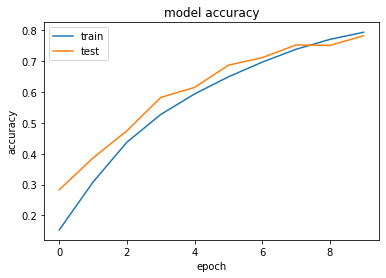

In [2]:
import numpy

import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D,Conv1D,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train[0:49984]
y_train = y_train[0:49984]
X_test = X_test[0:9984]
y_test = y_test[0:9984]

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]


# Function to create a normal convolutional block // Removed from RESNET and added here
def non_res_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu',
                      padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

# Create the model
model = Sequential()
# Block 1
model.add(Conv2D(64, (3, 3), batch_input_shape=(64, 32, 32, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(FractionalPooling2D(pool_ratio=(1, 1.6, 1.6, 1),pseudo_random = True,overlap=True))
# Block 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(FractionalPooling2D(pool_ratio=(1, 1.25, 1.25, 1),pseudo_random = True,overlap=True))
# Block 3
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(FractionalPooling2D(pool_ratio=(1, 1.6, 1.6, 1),pseudo_random = True,overlap=True))
# Block 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(FractionalPooling2D(pool_ratio=(1, 1.25, 1.25, 1),pseudo_random = True,overlap=True))
# Block 5
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(FractionalPooling2D(pool_ratio=(1, 1.6, 1.6, 1),pseudo_random = True,overlap=True))
# Block 6
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(alpha = 0.3))
model.add(FractionalPooling2D(pool_ratio=(1, 1.25, 1.25, 1),pseudo_random = True,overlap=True))
model.add(Flatten())
# fc layer_1
model.add(Dense(4096))
model.add(LeakyReLU(alpha = 0.3))
# fc_layer_2
model.add(Dense(4096))
model.add(LeakyReLU(alpha = 0.3))

model.add(Dense(num_classes, activation='softmax'))

opt = keras.optimizers.Adadelta(0.1,decay=1e-4)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
print(model.summary())

checkpoint = ModelCheckpoint('Model.hdf5', monitor='val_loss', save_best_only = True, verbose=1, mode='min')

callbacks_list = [checkpoint]
#model.load_weights('Model.hdf5')
epochs = 10
results = model.fit(X_train, y_train, validation_data = [X_test,y_test], nb_epoch=epochs, batch_size=64, callbacks=callbacks_list)

# Plot model history
# summarize history for accuracy
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

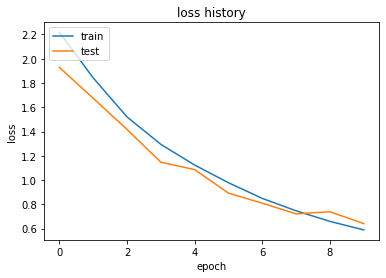

In [3]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [7]:
results

In [10]:
results.model.to_yaml

<bound method Network.to_yaml of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f159989c8d0>>